# Fractional VQE Portfolio Optimization

This notebook implements a **fractional-weight formulation** of the portfolio optimization problem using a **Variational Quantum Eigensolver**.

### Contents

1. **Problem Setup**
   - Expected returns vector $μ$
   - Covariance matrix $Σ$
   - Risk-aversion parameter $λ$

2. **Quantum Ansatz**
   - Hardware-efficient $R_Y$ rotations (one per asset)
   - $⟨Z⟩$ expectation mapped to fractional weights

3. **Cost Function**
   - Mean–variance objective: $−μᵀw + λ wᵀΣw$
   - Soft constraints for $Σw=1$ and $w ≥ 0$

4. **Optimization**
   - PennyLane `AdamOptimizer` with autograd
   - Track cost convergence across iterations
    
5. **Results & Visualization**
   - Circuit drawing
   - Optimized weights
   - Bar chart and pie chart of allocation
   - Convergence plot

### Notes

- Ansatz is single-layer $R_Y$; extend with entanglers or depth for more expressivity
- Penalty scaling is data-driven
- Use different seeds or $λ$ values to test robustness

In [9]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane import draw_mpl
import os
os.makedirs("images", exist_ok=True)

np.random.seed(0)

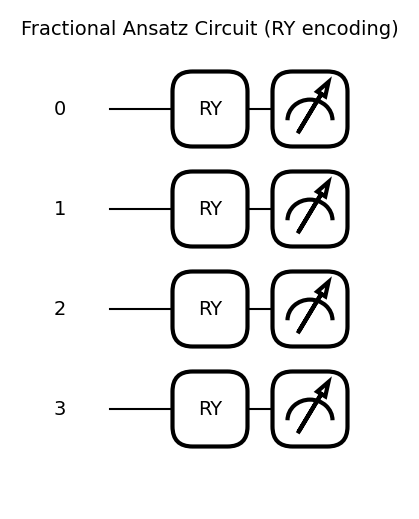

In [10]:
# Problem setup
mu = np.array([0.10, 0.20, 0.15, 0.12], requires_grad=False)  # Expected returns
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
], requires_grad=False)

n_assets = len(mu)
lam = 0.5  # Risk aversion parameter

# Quantum device and QNode
dev = qml.device("default.qubit", wires=n_assets, shots=None)

@qml.qnode(dev, interface="autograd")
def qnode(thetas):
    # Hardware-efficient R_Y layer
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)

    # Return ⟨Z⟩ for each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]

def angles_to_weights(thetas):
    # From ⟨Z⟩ to probability of |1⟩
    z = qml.math.stack(qnode(thetas))
    w = (1.0 - z) * 0.5  # In [0,1]

    # Soft simplex projection via normalization
    s = qml.math.sum(w)
    return w / (s + 1e-12), z

def scaled_penalty(mu, Sigma):
    # Scale penalties to objective magnitude
    ret_scale = float(np.sum(np.abs(mu)))
    risk_scale = float(np.trace(Sigma))
    base = max(ret_scale, risk_scale, 1e-3)
    return 50.0 * base, 10.0 * base

def objective(thetas):
    w, _ = angles_to_weights(thetas)
    expected_return = qml.math.dot(mu, w)
    risk = qml.math.dot(w, qml.math.dot(Sigma, w))

    # Soft constraints
    p_sum, p_neg = scaled_penalty(mu, Sigma)
    c_sum = p_sum * (qml.math.sum(w) - 1.0) ** 2
    c_neg = p_neg * qml.math.sum(qml.math.maximum(-w, 0.0))  # Barrier if any w<0 (rare but safe)
    return -(expected_return) + lam * risk + c_sum + c_neg

# Draw the circuit
sample_thetas = np.linspace(0, np.pi, n_assets)
fig, ax = draw_mpl(qnode)(sample_thetas)
fig.suptitle("Fractional Ansatz Circuit (RY encoding)", fontsize=14)
plt.savefig("images/Fractional_VQE_Circuit.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# Optimize
thetas = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.3)
steps = 75
history = []

for t in range(steps):
    thetas, cost = opt.step_and_cost(objective, thetas)
    if (t+1) % 5 == 0:
        w, z = angles_to_weights(thetas)
        history.append(float(cost))
        print(f"step {t+1:03d}  cost={float(cost):.6f}  sum(w)={float(np.sum(w)):.4f}")

step 005  cost=-0.156872  sum(w)=1.0000
step 010  cost=-0.171512  sum(w)=1.0000
step 015  cost=-0.176834  sum(w)=1.0000
step 020  cost=-0.177469  sum(w)=1.0000
step 025  cost=-0.178199  sum(w)=1.0000
step 030  cost=-0.179707  sum(w)=1.0000
step 035  cost=-0.179134  sum(w)=1.0000
step 040  cost=-0.179802  sum(w)=1.0000
step 045  cost=-0.179863  sum(w)=1.0000
step 050  cost=-0.179791  sum(w)=1.0000
step 055  cost=-0.179990  sum(w)=1.0000
step 060  cost=-0.179948  sum(w)=1.0000
step 065  cost=-0.179962  sum(w)=1.0000
step 070  cost=-0.179994  sum(w)=1.0000
step 075  cost=-0.179986  sum(w)=1.0000


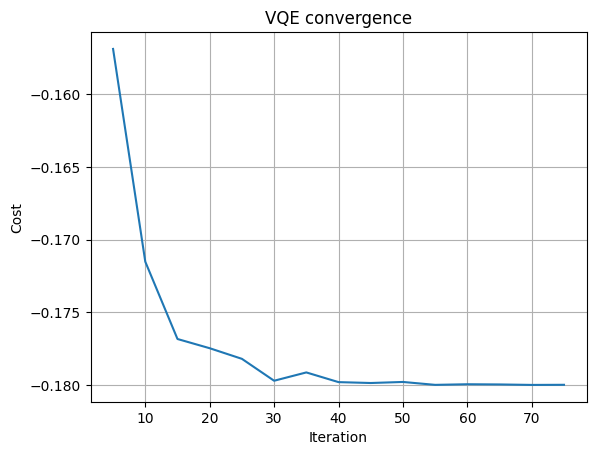

In [12]:
# Convergence plot
plt.figure()
plt.plot(range(5, steps+1, 5), history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("VQE convergence")
plt.grid(True)
plt.savefig("images/Fractional_VQE_Convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# Results
w_opt, _ = angles_to_weights(thetas)
w_opt = w_opt / (np.sum(w_opt) + 1e-12)

print("\nOptimized allocation")
for i, w in enumerate(w_opt):
    print(f"Asset {i+1}: {float(w)*100:.2f}%")


Optimized allocation
Asset 1: 0.00%
Asset 2: 99.92%
Asset 3: 0.07%
Asset 4: 0.01%


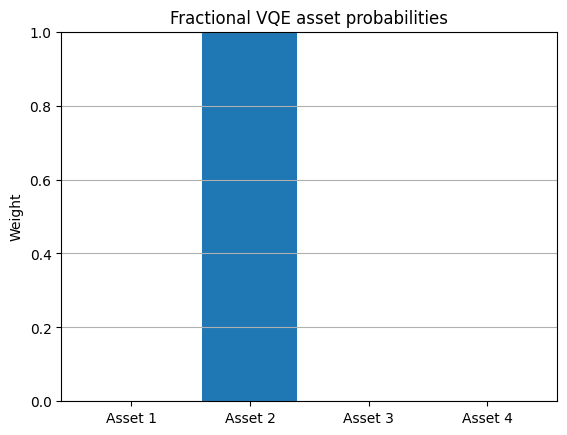

In [14]:
# Bar chart
plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n_assets)], w_opt)
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.title("Fractional VQE asset probabilities")
plt.grid(axis="y")
plt.savefig("images/Fractional_VQE_Probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

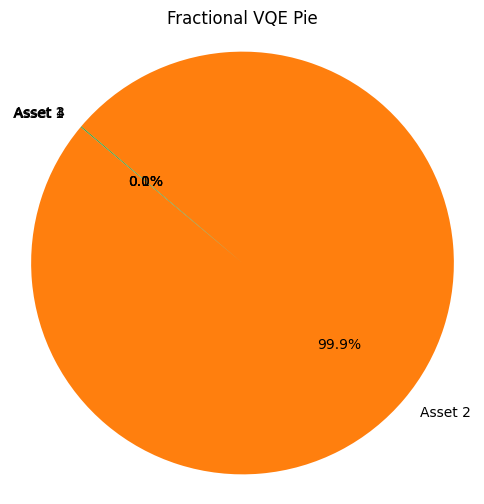

In [15]:
# Pie chart
plt.figure(figsize=(6,6))
plt.pie(w_opt, labels=[f"Asset {i+1}" for i in range(n_assets)], autopct="%1.1f%%", startangle=140)
plt.title("Fractional VQE Pie")
plt.axis("equal")
plt.savefig("images/Fractional_VQE_Pie.png", dpi=300, bbox_inches="tight")
plt.show()

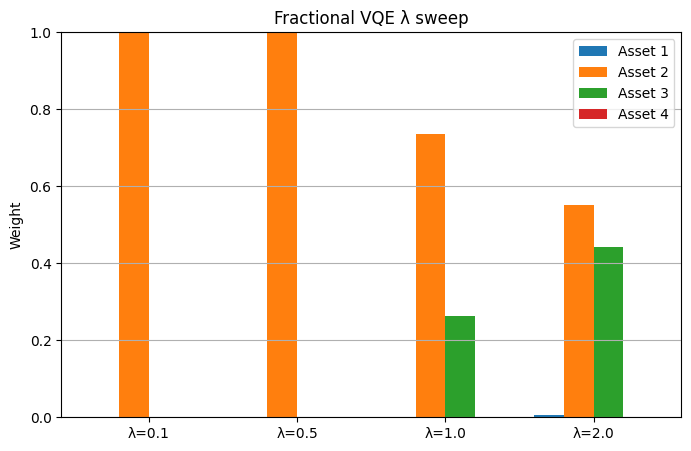

In [ ]:
# Sweep lambdas
lambdas = [0.1, 0.5, 1.0, 2.0]
allocs = []
for lam in lambdas:
    def obj_lam(th):  # wrap with new λ
        w, _ = angles_to_weights(th)
        ret = qml.math.dot(mu, w)
        risk = qml.math.dot(w, qml.math.dot(Sigma, w))
        p_sum, p_neg = scaled_penalty(mu, Sigma)
        return -(ret) + lam * risk + p_sum * (qml.math.sum(w)-1)**2 + p_neg * qml.math.sum(qml.math.maximum(-w, 0.0))
    th = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)
    opt = qml.AdamOptimizer(0.2)
    for _ in range(60): th, _ = opt.step_and_cost(obj_lam, th)
    w, _ = angles_to_weights(th)
    w = w/(np.sum(w)+1e-12)
    allocs.append(qml.numpy.array(w))
allocs = np.vstack(allocs)

#Plot bar chart for multiple values
x = np.arange(len(lambdas))
bw = 0.2
plt.figure(figsize=(8,5))
for i in range(n_assets): plt.bar(x+i*bw, allocs[:, i], bw, label=f"Asset {i+1}")
plt.xticks(x + bw*(n_assets-1)/2, [f"λ={l}" for l in lambdas])
plt.ylim(0,1)
plt.ylabel("Weight")
plt.title("Fractional VQE λ sweep")
plt.legend()
plt.grid(axis="y")
plt.savefig("images/Fractional_VQE_Lambda_Sweep.png", dpi=200, bbox_inches="tight")
plt.show()